In [2]:
# Basic constants

OUTPUT_DIR = '/home/ubuntu/visual_search_assistant/M3/results'
FACE_LIB_DIR = '/home/ubuntu/visual_search_assistant/M3/library/'
DATA_DIR = '/home/ubuntu/visual_search_assistant/data'
SAMPLE_FRAME_FREQ = 2
SAMPLE_CLUSTER_FREQ = 20
LOG_FREQ = 50

batch_size = 128

input_video = None
output_video = None


## Download Test Videos

Functions to download youtube video from link and clip them 

In [79]:
from pytube import YouTube 
from moviepy.editor import *

def download_video(link,output_path,output_title=None):
    yt = YouTube(link)
    video_stream = yt.streams.first()
    video_stream.download(output_path=output_path,filename=output_title)
    print('Download complete for %s' % video_stream.title)
    return video_stream.title


def clip_video(video_pth,output_pth,time):
    """
    video_pth: /path/to/input/video
    output_pth: /path/to/output/video
    time: list of start and end time in seconds to clip video
    """

    start,end=time
    clip = VideoFileClip(video_pth).subclip(start,end)
    if output_pth is None:
        name = video_pth.split('/')[-1].split('.')[0]
        new_name = name + '_%d_%d'%(start,end)
        output_pth = video_pth.replace(name,new_name)
        
    #import pdb; pdb.set_trace()
    clip.write_videofile(output_pth)
        

Specify the link and download

In [72]:
download_link = 'https://www.youtube.com/watch?v=oHddkxW5IqU'
download_link = 'https://www.youtube.com/watch?v=X4uo7uKR61M'
fname = 'radio_star_.mp4'
fname = 'parks_and_rec_.mp4'

output_pth = os.path.join(DATA_DIR,fname)
if not os.path.exists(output_pth):
    download_video(download_link,DATA_DIR,fname)

Download complete for Donna Wakes Up Everyday And Chooses Being Cool | Parks and Recreation


In [75]:
from IPython.core.display import Video
Video('/home/ubuntu/visual_search_assistant/data/Donna Wakes Up Everyday And Chooses Being Cool  Parks and Recreation.mp4')

## Library of face embeddings

In [3]:
import os
import face_recognition

faces = os.listdir(FACE_LIB_DIR)
all_embeddings = []
all_names = []
for file in faces:
    face = face_recognition.load_image_file(os.path.join(FACE_LIB_DIR,file))
    all_embeddings.append(face_recognition.face_encodings(face)[0])
    name = file.split('/')[-1].split('.')[0]
    all_names.append(name)
    

In [4]:
import os
import cv2
import pickle
import numpy as np


def process_video(input_pth,output_pth=None,use_gpu=True,recognition=False,detection_threshold=0.7,
                  result_dir=None,max_frames=None,sample_cluster_freq=2,sample_freq=2,batch_size=1):
    if output_pth is None:
        output_pth = os.path.join(OUTPUT_DIR,input_pth.split('/')[-1])
    if use_gpu:
        batch_size = 16
    
    if result_dir is None:
        import pdb;pdb.set_trace()
        input_name = input_pth.split('/')[-1].split('.')[0]
        result_dir = os.path.join(OUTPUT_DIR,input_name)
    
    if not os.path.exists(result_dir):
        sampled_face_dir = os.path.join(result_dir,'sampled_faces')
        os.makedirs(sampled_face_dir)
    else:
        print('Error result dir %s already exists! aborting' % result_dir)
        sampled_face_dir = os.path.join(result_dir,'sampled_faces')
#         return
    
    
    cluster_dict = {}
    
    video_capture = cv2.VideoCapture(input_pth)

    frame_width = int(video_capture.get(3))
    frame_height = int(video_capture.get(4))
    
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    out = cv2.VideoWriter(output_pth, fourcc, 30.0, (frame_width, frame_height))
    
    frame_count = 0
    
    frames = []
    print('='*20,'Start Face Detection and Recognition','='*20)
    while video_capture.isOpened():
        ret, frame = video_capture.read()
        
        if not ret or (max_frames and frame_count > max_frames):
            break
        if frame_count % LOG_FREQ == LOG_FREQ -1:
            print('Processed %d frames'% frame_count)
            
        frame_count += 1
        
        # skip frames
        if frame_count % sample_freq > 0:
            continue
            
        frames.append(frame)
        if len(frames) == batch_size:
#             import pdb;pdb.set_trace()
            batch_face_locations = face_recognition.batch_face_locations(frames)
            for frame_idx,face_locations in enumerate(batch_face_locations):
                number_of_faces_in_frame = len(face_locations)
                
                fno = frame_count - batch_size + frame_idx
                frame = frames[frame_idx]
                
                
                embeddings = face_recognition.face_encodings(frame,face_locations)
                for face_idx,(embd,(top,right,bottom,left)) in enumerate(zip(embeddings,face_locations)):
                    # Draw a box around the face
                    cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), 2)
                    # Draw a label with a name below the face
                    cv2.rectangle(frame, (left, bottom + 35), (right, bottom), (0, 0, 255), cv2.FILLED)
                    
                    
                    # write label
                    face_dist = face_recognition.face_distance(all_embeddings,embd)
                    label_idx = np.argmin(face_dist)
                    name = all_names[label_idx] if face_dist[label_idx] > detection_threshold else 'Unknown'
                    font = cv2.FONT_HERSHEY_DUPLEX
                    cv2.putText(frame, name, (left + 6, bottom + 6), font, 0.5, (255, 255, 255), 1)
                    
                    
                    # save face image for clustering
                    if frame_idx % sample_cluster_freq ==0:
                        fname = '%.3d_%.3d.png'%(fno,face_idx)
                        face_img = frame[top:bottom,left:right,:]
                        # save face image
                        cv2.imwrite(os.path.join(sampled_face_dir,fname),face_img)
                        # save embd in dict
                        cluster_dict[fname.split('.')[0]] = embd
                                
                out.write(frame)
            frames = []
                
                
    video_capture.release()
    out.release()
    
    # save sampled embeddings as pickle file
    import pdb;pdb.set_trace()
    cluster_meta_file = os.path.join(result_dir,'embeddings.pickle')
    with open(cluster_meta_file,'wb') as f:
        pickle.dump(cluster_dict,f,protocol=pickle.HIGHEST_PROTOCOL)
    
    print('='*15,'Done Processing %s to %s' % (input_pth,output_pth),'='*15)
        

In [4]:
test_input_video = '/home/ubuntu/visual_search_assistant/data/radio_star_10_20.mp4'
process_video(test_input_video,max_frames=64,batch_size=16)

> <ipython-input-3-a95339412212>(16)process_video()
-> input_name = input_pth.split('/')[-1].split('.')[0]
(Pdb) c
Error result dir /home/ubuntu/visual_search_assistant/M3/results/radio_star_10_20 already exists! aborting
==================== Start Face Detection and Recognition ====================
Processed 49 frames
> <ipython-input-3-a95339412212>(101)process_video()
-> cluster_meta_file = os.path.join(result_dir,'embeddings.pickle')
(Pdb) cluster_dict
{'016_000': array([-3.21011916e-02,  6.64761588e-02,  6.10604770e-02, -5.89057058e-02,
       -5.73804229e-02, -3.53032202e-02, -5.80256060e-02, -1.88536063e-01,
        9.47577208e-02, -1.56583145e-01,  2.57963955e-01, -1.01327851e-01,
       -1.97271317e-01, -1.11021832e-01, -1.05824322e-03,  2.11702824e-01,
       -1.97926998e-01, -1.77311271e-01, -7.91919976e-02,  6.40822574e-02,
       -2.30759420e-02, -3.23135406e-03,  2.90714800e-02,  2.28887051e-02,
       -4.90087718e-02, -3.16991091e-01, -1.53888226e-01, -3.79037187e-02,
  

(Pdb) c
=============== Done Processing /home/ubuntu/visual_search_assistant/data/radio_star_10_20.mp4 to /home/ubuntu/visual_search_assistant/M3/results/radio_star_10_20.mp4 ===============


### Check sampled faces & embeddings

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import glob

def display_multiple_images(images,names,columns=10,figsize=(20,10)):
    plt.figure(figsize=figsize)
    plt.subplots_adjust(wspace=0, hspace=0)
    for i, (image,name) in enumerate(zip(images,names)):
        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(name) 
        

num_images = 30
%matplotlib inline

print('='*10,'Display sampled faces','='*10)
print("title is in <(frame number)_(detected face id)> format")

images = []
names = []
for img_path in glob.glob(os.path.join(result_dir,'sampled_faces','*.png')):
    images.append(mpimg.imread(img_path))
    names.append(img_path.split('/')[-1].split('.')[0])
    if len(images) == num_images:
        break
        
        
display_multiple_images(images,names)

========== Display sampled faces ==========
title is in <(frame number)_(detected face id)> format


NameError: name 'result_dir' is not defined

In [6]:
embd_pkl_file = '/home/ubuntu/visual_search_assistant/M3/results/radio_star_10_20/embeddings.pickle'
result_dir = '/home/ubuntu/visual_search_assistant/M3/results/radio_star_10_20'

import pickle
import numpy as np

with open(embd_pkl_file,'rb') as rf:
    embedding_dict = pickle.load(rf)

embedding_dict.keys()

dict_keys(['016_000', '016_001', '018_000', '018_001', '020_000', '020_001', '022_000', '022_001', '024_000', '024_001', '026_000', '026_001', '028_000', '028_001', '030_000', '030_001', '048_000', '048_001', '048_002', '050_000', '050_001', '052_000', '052_001', '054_000', '054_001', '056_000', '056_001', '058_000', '060_000', '062_000', '062_001'])

## Cluster Some Faces!
Use a clustering algorithm from Scikit
https://pyimagesearch.com/2018/07/09/face-clustering-with-python/

In [7]:
embeddings = np.array(list(embedding_dict.values()))
names = np.array(list(embedding_dict.keys()))

In [8]:
from sklearn.cluster import DBSCAN

clt = DBSCAN(metric="euclidean", n_jobs=-1)
clt.fit(embeddings)

# determine the total number of unique faces found in the dataset
labelIDs = np.unique(clt.labels_)
numUniqueFaces = len(np.where(labelIDs > -1)[0])
print("[INFO] # unique faces: {}".format(numUniqueFaces))

print("Save clustered results in dict")
cluster = {}
# save separately as clusters
for cluster_idx in labelIDs:
    idxs = np.where(clt.labels_ == cluster_idx)
    cluster[cluster_idx] = names[idxs]

[INFO] # unique faces: 2
Save clustered results in dict


In [13]:
import cv2

# helper function for converting fnames to images for using imutils build_montages function
def fnames2images(fnames,dir=None):
    faces = []
    for fname in fnames:
        if not fname.endswith('.png'):
            fname = fname + '.png'
        image = cv2.imread(os.path.join(dir,fname))
        face = cv2.resize(image, (96,96))
        faces.append(face)
    return faces

#### Visualize the cluster results!

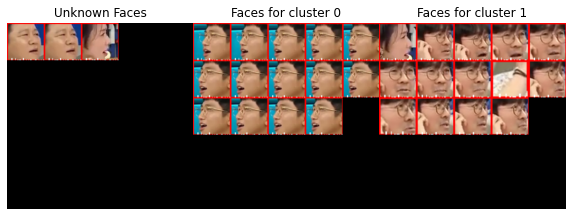

In [19]:
from imutils import build_montages

plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0, hspace=0)

for idx,(key,name_list) in enumerate(cluster.items()):
    faces = fnames2images(name_list,dir=os.path.join(result_dir,'sampled_faces'))
    montage = build_montages(faces,(96,96),(5,5))[0]
    title = "Faces for cluster %d" % key if key!=-1 else "Unknown Faces"
    plt.subplot(1,3,idx+1)
    plt.axis('off')
    plt.title(title)
    plt.imshow(cv2.cvtColor(montage,cv2.COLOR_BGR2RGB))
    